In [3]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [4]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
100% 60.3M/60.3M [00:04<00:00, 22.1MB/s]
100% 60.3M/60.3M [00:04<00:00, 15.7MB/s]


In [5]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [7]:
os.makedirs('test_dir',exist_ok=True)

In [8]:
project_name='FER_2013_EMOTION_DETECTION'
model_names=[
    'Custom_CNN_From_Scratch',
    'Custom_CNN_with_Augmentation',
    'VGG16_Transfer_Learning',
    'Resnet50_Transfer_Learning'
]
base_dir='/content/'
project_dir=os.path.join(base_dir,project_name)  # create a project directory
os.makedirs(project_dir,exist_ok=True) # create a path /content/FER_2013_EMOTION_DETECTION/(model_names)
# create  a subdirectory for each model
for each_model in model_names:
  model_dir=os.path.join(project_dir,each_model)
  os.makedirs(model_dir,exist_ok=True)

print(f'project directory structure created at:{project_dir}')

project directory structure created at:/content/FER_2013_EMOTION_DETECTION


data cleaning

In [9]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir): # root curr dir,dirs subdirectory in curr_root,file files in curr root
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

data analysis

In [10]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       angry  surprise  disgust  neutral  happy  fear   sad
train   3995      3171      436     4965   7215  4097  4830
      angry  surprise  disgust  neutral  happy  fear   sad
test    958       831      111     1233   1774  1024  1247


<Axes: >

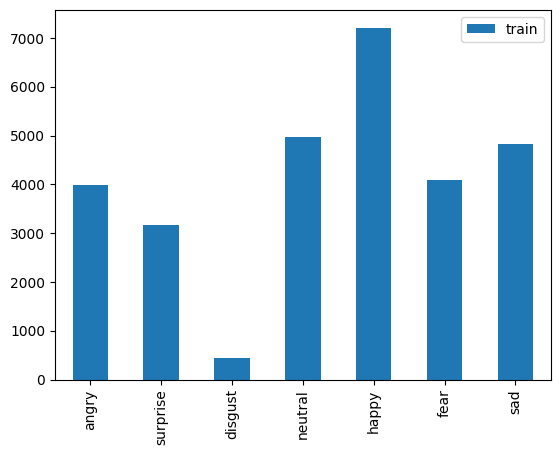

In [11]:
train_count.transpose().plot(kind='bar')

<Axes: >

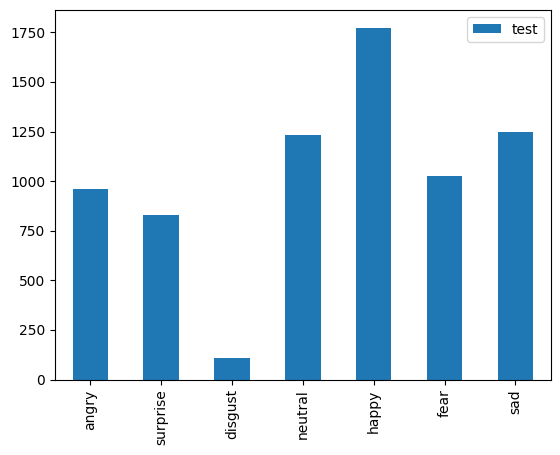

In [12]:
test_count.transpose().plot(kind='bar')

as we clearly see image the disgust has less number of image so i can say the class is imbalance

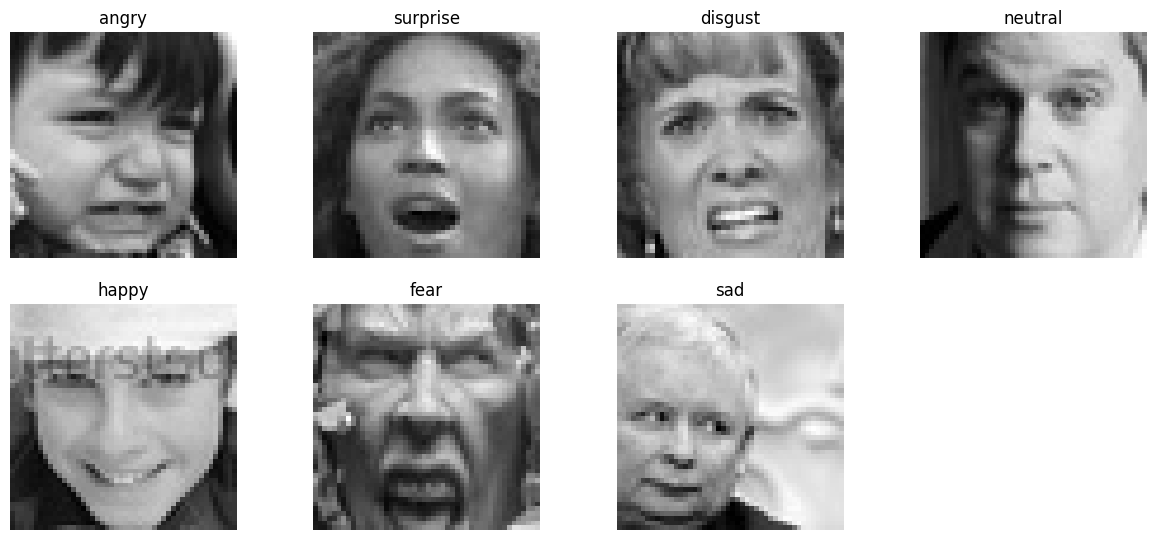

In [13]:
emotions=os.listdir(train_dir)
plt.figure(figsize=(15,10))
for i,emotion in enumerate(emotions,1):
  folder=os.path.join(train_dir,emotion)
  img_path=os.path.join(folder,os.listdir(folder)[42])
  img=plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img,cmap='gray')
  plt.title(emotion)
  plt.axis('off')

plotting random image

In [14]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()


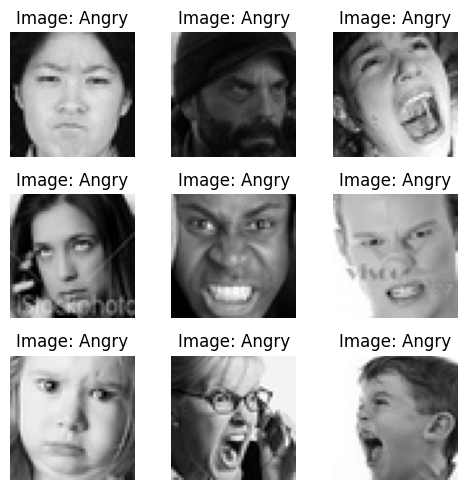

In [15]:
# Placeholder for the directory path
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

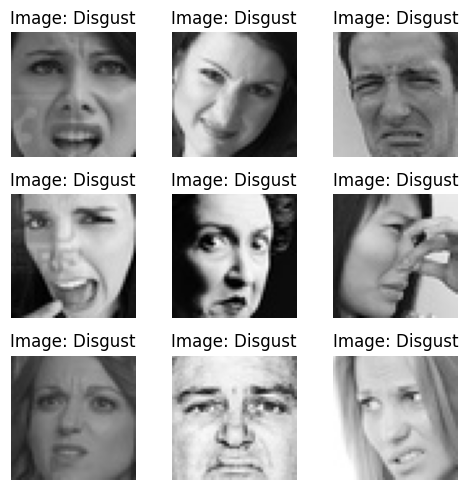

In [16]:
# Placeholder for the directory path
disgust_directory_path = '/content/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

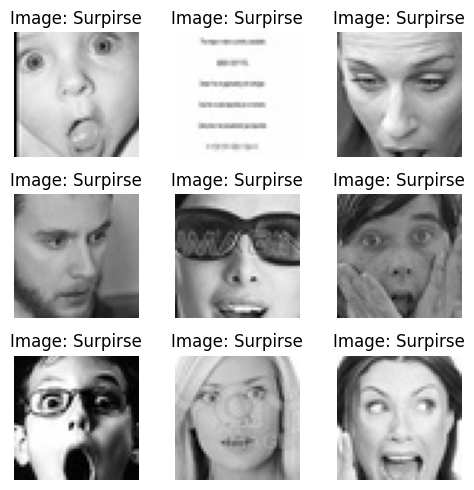

In [17]:
surpirse_directory_path = '/content/train/surprise'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

In [18]:
image='/content/train/angry/Training_10118481.jpg'
import cv2
img=cv2.imread(image)

if img is not None:
  print("shape",img.shape)
else:
  print("the image could not be loaded")

shape (48, 48, 3)


as we clearly see cv read the image in rgb format by default

In [19]:
image='/content/train/angry/Training_10118481.jpg'
import cv2
img=cv2.imread(image,cv2.IMREAD_GRAYSCALE) # read the image in greyscale format

if img is not None:
  print("shape",img.shape)
else:
  print("the image could not be loaded")

shape (48, 48)


In [20]:
train_data_dir='/content/train'
test_data_dir='/content/test'

In [21]:
# set some parameter
img_width,img_height=48,48
batch_size=64
epochs=10
num_classes=7

In [22]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
# acessing the labels for training data
train_class_labels=train_generator.class_indices
print(train_class_labels)

# accessing the labels for validation data
val_class_labels=validation_generator.class_indices
print(val_class_labels)

# accessing the labels for validation data
test_class_labels=test_generator.class_indices
print(test_class_labels)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [24]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 512)           │              

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 512)           │              

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [27]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

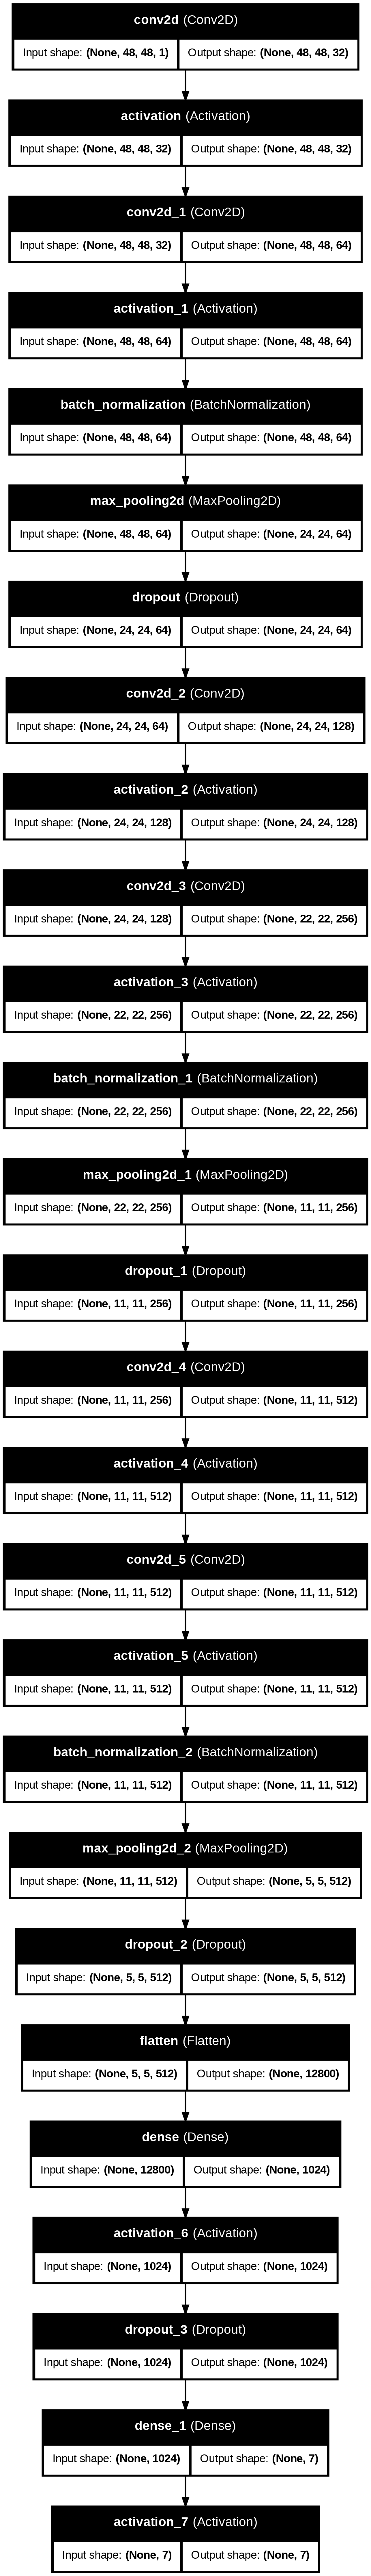

In [ ]:
plot_model(model,to_file='/content/FER_2013_EMOTION_DETECTION/Custom_CNN_From_Scratch/Architecture.png',show_shapes=True,show_layer_names=True)

In [28]:
# file path for the model checkpoint
cnn_path='/content/FER_2013_EMOTION_DETECTION/Custom_CNN_From_Scratch'
name='Custom_cnn_model.keras'
chk_path=os.path.join(cnn_path,name)
chk_path

'/content/FER_2013_EMOTION_DETECTION/Custom_CNN_From_Scratch/Custom_cnn_model.keras'

In [29]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [30]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [31]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Switch to a different metric if needed
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001
)



In [32]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [33]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr,csv_logger]  # Adjusted as per your use-case

In [34]:
train_generator.samples

22968

In [35]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2505 - loss: 13.2897
Epoch 1: val_loss improved from inf to 12.70162, saving model to /content/FER_2013_EMOTION_DETECTION/Custom_CNN_From_Scratch/Custom_cnn_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 64s 129ms/step - accuracy: 0.2506 - loss: 13.2872 - val_accuracy: 0.1759 - val_loss: 12.7016 - learning_rate: 1.0000e-04
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3459 - loss: 10.6819
Epoch 2: val_loss improved from 12.70162 to 9.47670, saving model to /content/FER_2013_EMOTION_DETECTION/Custom_CNN_From_Scratch/Custom_cnn_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 26s 72ms/step - accuracy: 0.3460 - loss: 10.6804 - val_accuracy: 0.3893 - val_loss: 9.4767 - learning_rate: 1.0000e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3994 - loss: 8.5855
Epoch 3: val_loss improved from 9.47670 to 7.19299, saving model to /content/FER_2013_EMOTION_DETECTION/Custom_CNN_From_Scratch/Custom_cnn_model.ker

In [36]:
def plot_training_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

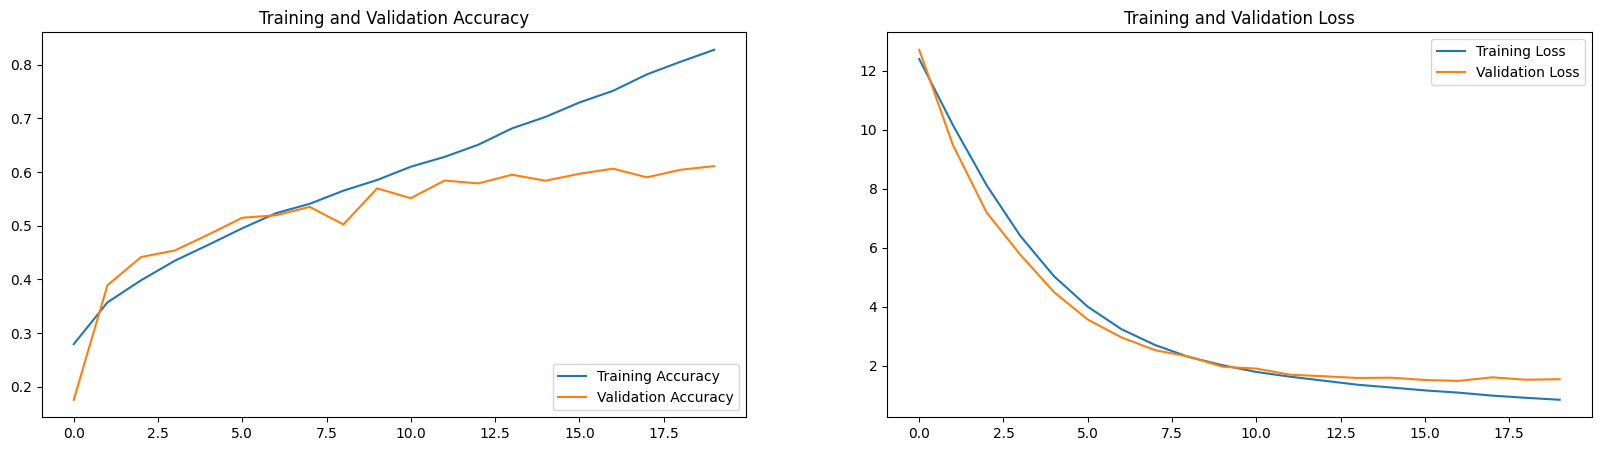

In [ ]:
plot_training_history(history)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


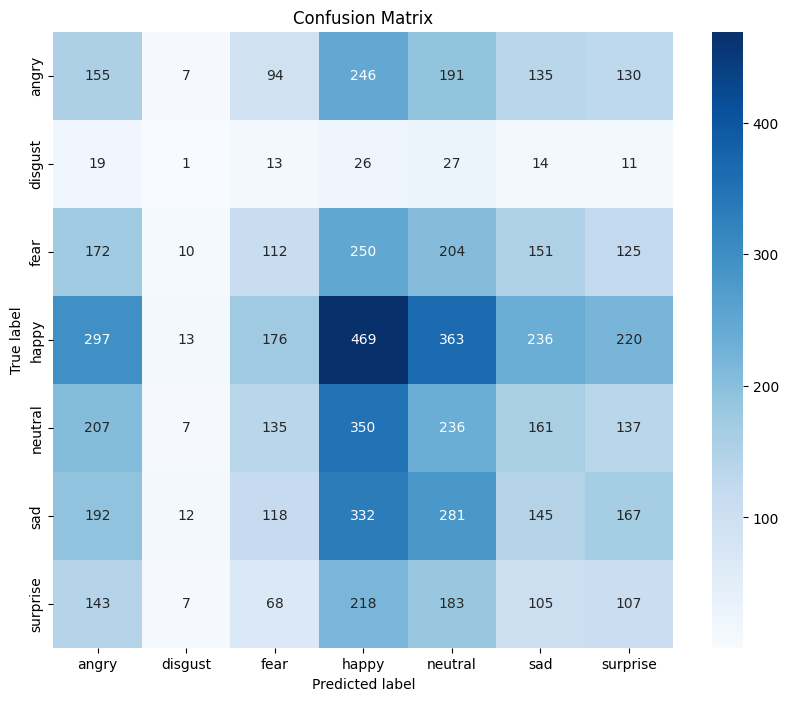

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.16      0.14       958
     disgust       0.02      0.01      0.01       111
        fear       0.16      0.11      0.13      1024
       happy       0.25      0.26      0.26      1774
     neutral       0.16      0.19      0.17      1233
         sad       0.15      0.12      0.13      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



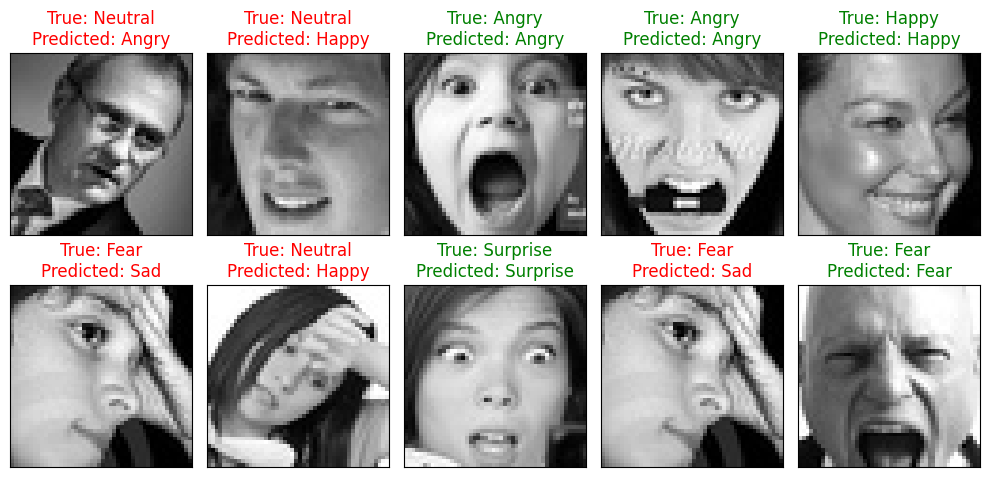

In [ ]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

Model 2  Augmentatation

In [37]:
train_data_dir='/content/train'
test_data_dir='/content/test'


# set some parameter
img_width,img_height=48,48
batch_size=64
epochs=10
num_classes=7


data_genrator=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)



test_data_generator=ImageDataGenerator(rescale=1./255)


train_generator=data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)


validation_generator=data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)



test_generator=data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',

)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


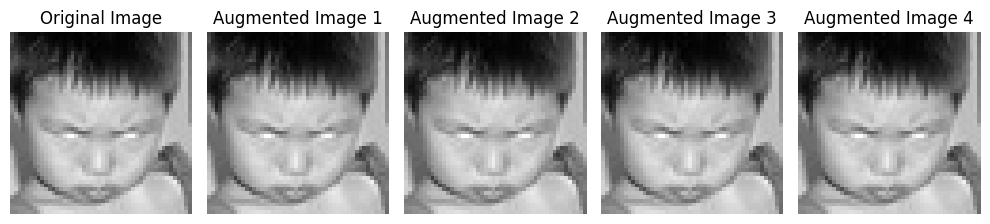

In [38]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [39]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_EMOTION_DETECTION/Custom_CNN_with_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2427 - loss: 13.4030
Epoch 1: val_loss improved from inf to 12.78720, saving model to /content/FER_2013_EMOTION_DETECTION/Custom_CNN_with_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 63s 115ms/step - accuracy: 0.2427 - loss: 13.4002 - val_accuracy: 0.1740 - val_loss: 12.7872 - learning_rate: 1.0000e-04
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3321 - loss: 10.6414
Epoch 2: val_loss improved from 12.78720 to 9.32422, saving model to /content/FER_2013_EMOTION_DETECTION/Custom_CNN_with_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.3322 - loss: 10.6399 - val_accuracy: 0.3663 - val_loss: 9.3242 - learning_rate: 1.0000e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3872 - loss: 8.5280
Epoch 3: val_loss improved from 9.32422 to 7.13871, saving model to /content/FER_2013_EMOTION_DETECTION/Custom_CNN_wit

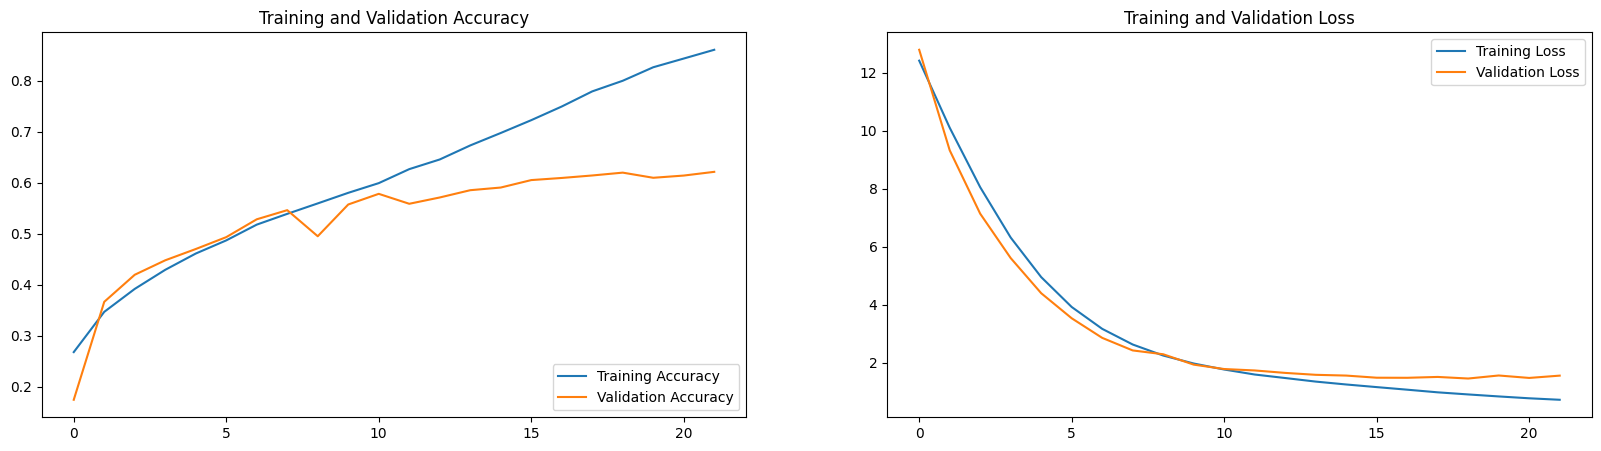

In [40]:
plot_training_history(history)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step


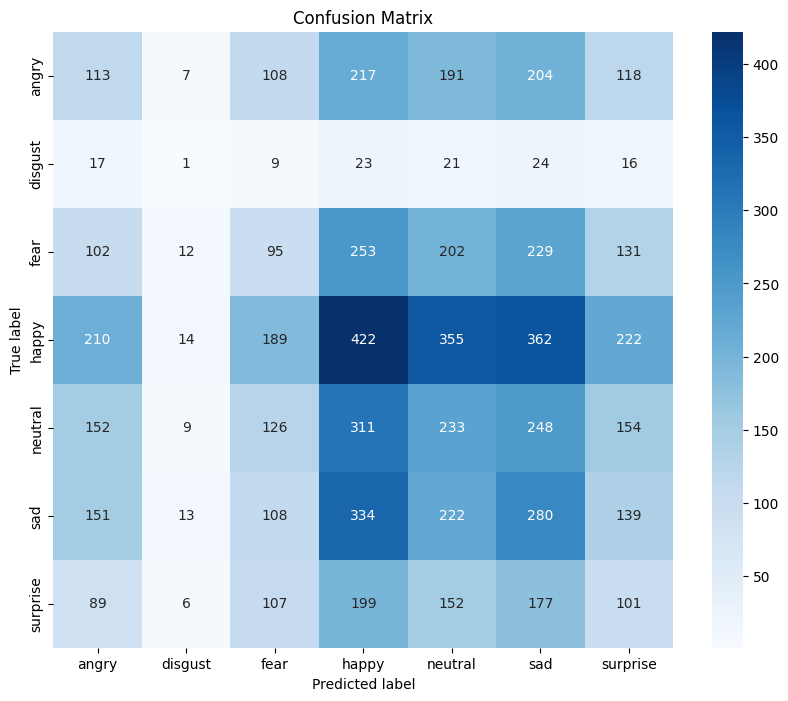

In [41]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [42]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.12      0.13       958
     disgust       0.02      0.01      0.01       111
        fear       0.13      0.09      0.11      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.17      0.19      0.18      1233
         sad       0.18      0.22      0.20      1247
    surprise       0.11      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



vgg16

In [43]:
from keras.applications.vgg16 import VGG16

In [44]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [45]:
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [47]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()

Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 30,939,143 (118.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [48]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_EMOTION_DETECTION/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [49]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    epochs=20,
                    callbacks = callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.2995 - loss: 1.7752
Epoch 1: val_loss improved from inf to 1.34698, saving model to /content/FER_2013_EMOTION_DETECTION/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - accuracy: 0.2997 - loss: 1.7747 - val_accuracy: 0.4898 - val_loss: 1.3470 - learning_rate: 1.0000e-04
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.4695 - loss: 1.3880
Epoch 2: val_loss improved from 1.34698 to 1.28926, saving model to /content/FER_2013_EMOTION_DETECTION/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 421s 937ms/step - accuracy: 0.4695 - loss: 1.3880 - val_accuracy: 0.5096 - val_loss: 1.2893 - learning_rate: 1.0000e-04
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.5120 - loss: 1.2902
Epoch 3: val_loss improved from 1.28926 to 1.20584, saving model to /content/FER_2013_EMOTION_DETECTION/VGG16_Transfer_Learning/V

113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 353ms/step


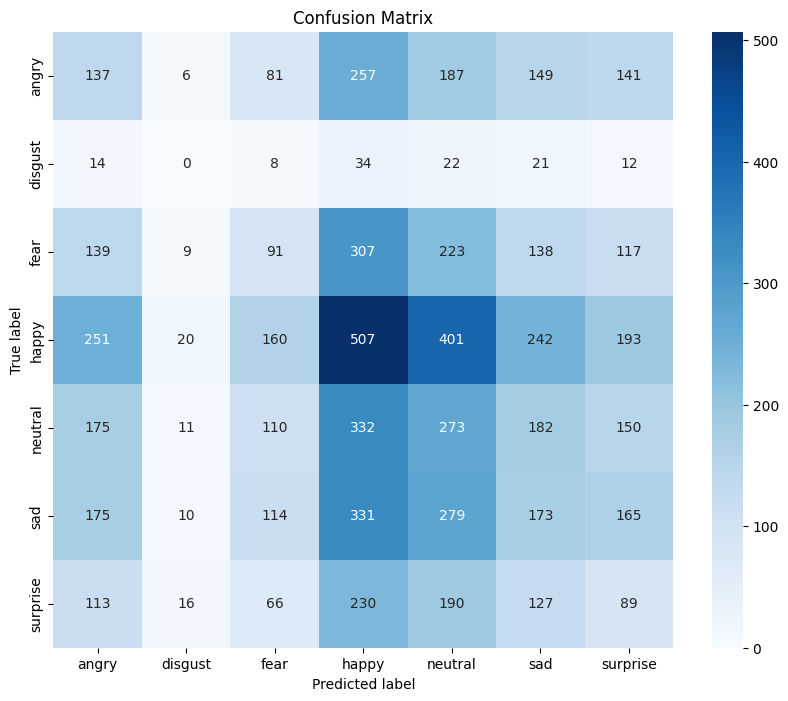

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.14      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.09      0.11      1024
       happy       0.25      0.29      0.27      1774
     neutral       0.17      0.22      0.19      1233
         sad       0.17      0.14      0.15      1247
    surprise       0.10      0.11      0.10       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178

